In [1]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelForMaskedLM
from tqdm import tqdm
import pandas as pd
from scipy import stats
from collections import Counter
from matplotlib import pyplot as plt

In [3]:
# MovieLens names are wrong, but use it to initialize
id2name = {}
for line in open('../MovieLens-1M/movies.dat'): 
    id, name, type = line.strip().split('::')
    id = int(id)
    assert(name[-1] == ')' and name[-6] == '(')
    id2name[id] = name[:-6].strip()

# Update new name from Hao's metadata, some ids are missing
for item in pd.read_csv('../MovieLens-1M/ML1M_Meta_3670.csv').values.tolist():
    id2name[item[0]] = item[3]

In [4]:
oldid2newid = {} # trim empty ids
for new_id, old_id in enumerate(sorted(id2name.keys())): oldid2newid[old_id] = new_id
id2name = [id2name[id] for id in sorted(id2name.keys())]

In [5]:
user2ids = {}
for line in open('../MovieLens-1M/ratings.dat'):
    user, id, rating, time = line.strip().split('::')
    user, id, rating, time = int(user), oldid2newid[int(id)], int(rating), int(time)
    if rating != 5: continue
    if user not in user2ids: user2ids[user] = []
    user2ids[user].append((id, time))
for user in user2ids:
    user2ids[user] = sorted(user2ids[user], key=lambda x: x[1])
    user2ids[user], _ = zip(*user2ids[user])

In [6]:
print('# user:', len(user2ids), ',', '# movie:', len(id2name), ',', '# interaction:', sum([len(user2ids[user]) for user in user2ids]))
print('History:', stats.describe([len(user2ids[user]) for user in user2ids]))
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
print('# words in movie name:', stats.describe([len(name.split()) for name in id2name]))
print('# tokens in movie name:', stats.describe([len(tokenizer(name, add_special_tokens=False)['input_ids']) for name in id2name]))

# user: 6014 , # movie: 3883 , # interaction: 226310
History: DescribeResult(nobs=6014, minmax=(1, 571), mean=37.63052876621217, variance=1906.4176010175493, skewness=3.4206998467083447, kurtosis=19.41638792240454)
# words in movie name: DescribeResult(nobs=3883, minmax=(1, 15), mean=2.8532062838011845, variance=2.672933431676114, skewness=1.5587508576280893, kurtosis=4.413184077254987)
# tokens in movie name: DescribeResult(nobs=3883, minmax=(1, 25), mean=4.110739119237703, variance=5.747651256756257, skewness=2.024892296904092, kurtosis=7.619923800325971)


In [46]:
def save_jsonl(data, filename):
    with open(filename, 'w') as fout:
        for item in data:
            fout.write(json.dumps(item) + '\n')

data = [{'user': user, 'ids': user2ids[user][-7:]} for user in user2ids if len(user2ids[user]) >= 7]
print(len(data))
save_jsonl(data, 'data.jsonl')
json.dump(id2name, open('id2name.json', 'w'))

5337


In [38]:
user = 4
print(data[user - 1]['ids'], len(data[user - 1]['ids']))
print(user2ids[user], len(user2ids[user]))

(3399, 257, 1180, 1366, 1959, 1183, 2623, 2878, 1220, 1885) 10
(3399, 257, 1180, 1366, 1959, 1183, 2623, 2878, 1220, 1885) 10


('American Beauty', 'Saving Private Ryan', 'The Sixth Sense', "Schindler's List", 'Braveheart') (59, 50, 48, 40, 37)


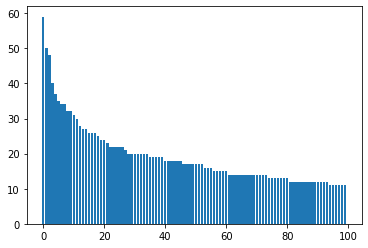

In [45]:
idx = -7
names, freqs = zip(*Counter(id2name[item['ids'][idx]] for item in data).most_common())
plt.bar(range(100), freqs[:100])
print(names[:5], freqs[:5])